# Importing Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

In [2]:
train_data = pd.read_csv("/kaggle/input/playground-series-s4e7/train.csv")

In [3]:
train_data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [4]:
train_data.shape

(11504798, 12)

# Types of variables

In [5]:
train_data.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

In [6]:
train_data.id.nunique()

11504798

In [7]:
train_data.drop(columns = ["id"], inplace = True)

## let's inspect the variable values

In [8]:
for var in train_data.columns:
    print(f"{var}: {train_data[var].unique()[:20]} | {train_data[var].nunique()}\n")

Gender: ['Male' 'Female'] | 2

Age: [21 43 25 35 36 31 23 47 26 66 22 27 24 79 34 20 42 40 50 67] | 66

Driving_License: [1 0] | 2

Region_Code: [35. 28. 14.  1. 15. 47. 45.  8. 11.  3. 10. 12. 37. 50. 30. 46. 29. 16.
 26. 25.] | 54

Previously_Insured: [0 1] | 2

Vehicle_Age: ['1-2 Year' '> 2 Years' '< 1 Year'] | 3

Vehicle_Damage: ['Yes' 'No'] | 2

Annual_Premium: [65101. 58911. 38043.  2630. 31951. 28150. 27128. 40659. 31639. 27996.
 38104. 43746. 23692. 66887. 30226. 36389. 25769. 40797. 29698. 27677.] | 51728

Policy_Sales_Channel: [124.  26. 152. 156. 160.   8.  31. 157.  60. 122.  15.  30. 147.   1.
  63. 136. 154.  18. 135. 151.] | 152

Vintage: [187 288 254  76 294 197 190 262  36 125 215  30 203 259 245 150 240 242
 117 151] | 290

Response: [0 1] | 2



In [9]:
continuous = list(train_data.select_dtypes(exclude = "O").columns)[:-1]

categorical = list(train_data.select_dtypes(include = "O").columns)


print('There are {} continuous variables'.format(len(continuous)))
print('There are {} categorical variables'.format(len(categorical)))

There are 7 continuous variables
There are 3 categorical variables


In [10]:
continuous

['Age',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Annual_Premium',
 'Policy_Sales_Channel',
 'Vintage']

In [11]:
categorical

['Gender', 'Vehicle_Age', 'Vehicle_Damage']

# Variable characteristics

### missing data

In [12]:
train_data.isnull().mean()

Gender                  0.0
Age                     0.0
Driving_License         0.0
Region_Code             0.0
Previously_Insured      0.0
Vehicle_Age             0.0
Vehicle_Damage          0.0
Annual_Premium          0.0
Policy_Sales_Channel    0.0
Vintage                 0.0
Response                0.0
dtype: float64

There is no missing data.

### cardinality (number of different categories)

In [13]:
train_data[categorical].nunique()

Gender            2
Vehicle_Age       3
Vehicle_Damage    2
dtype: int64

there is no variable with highly cardinal.

### outliers

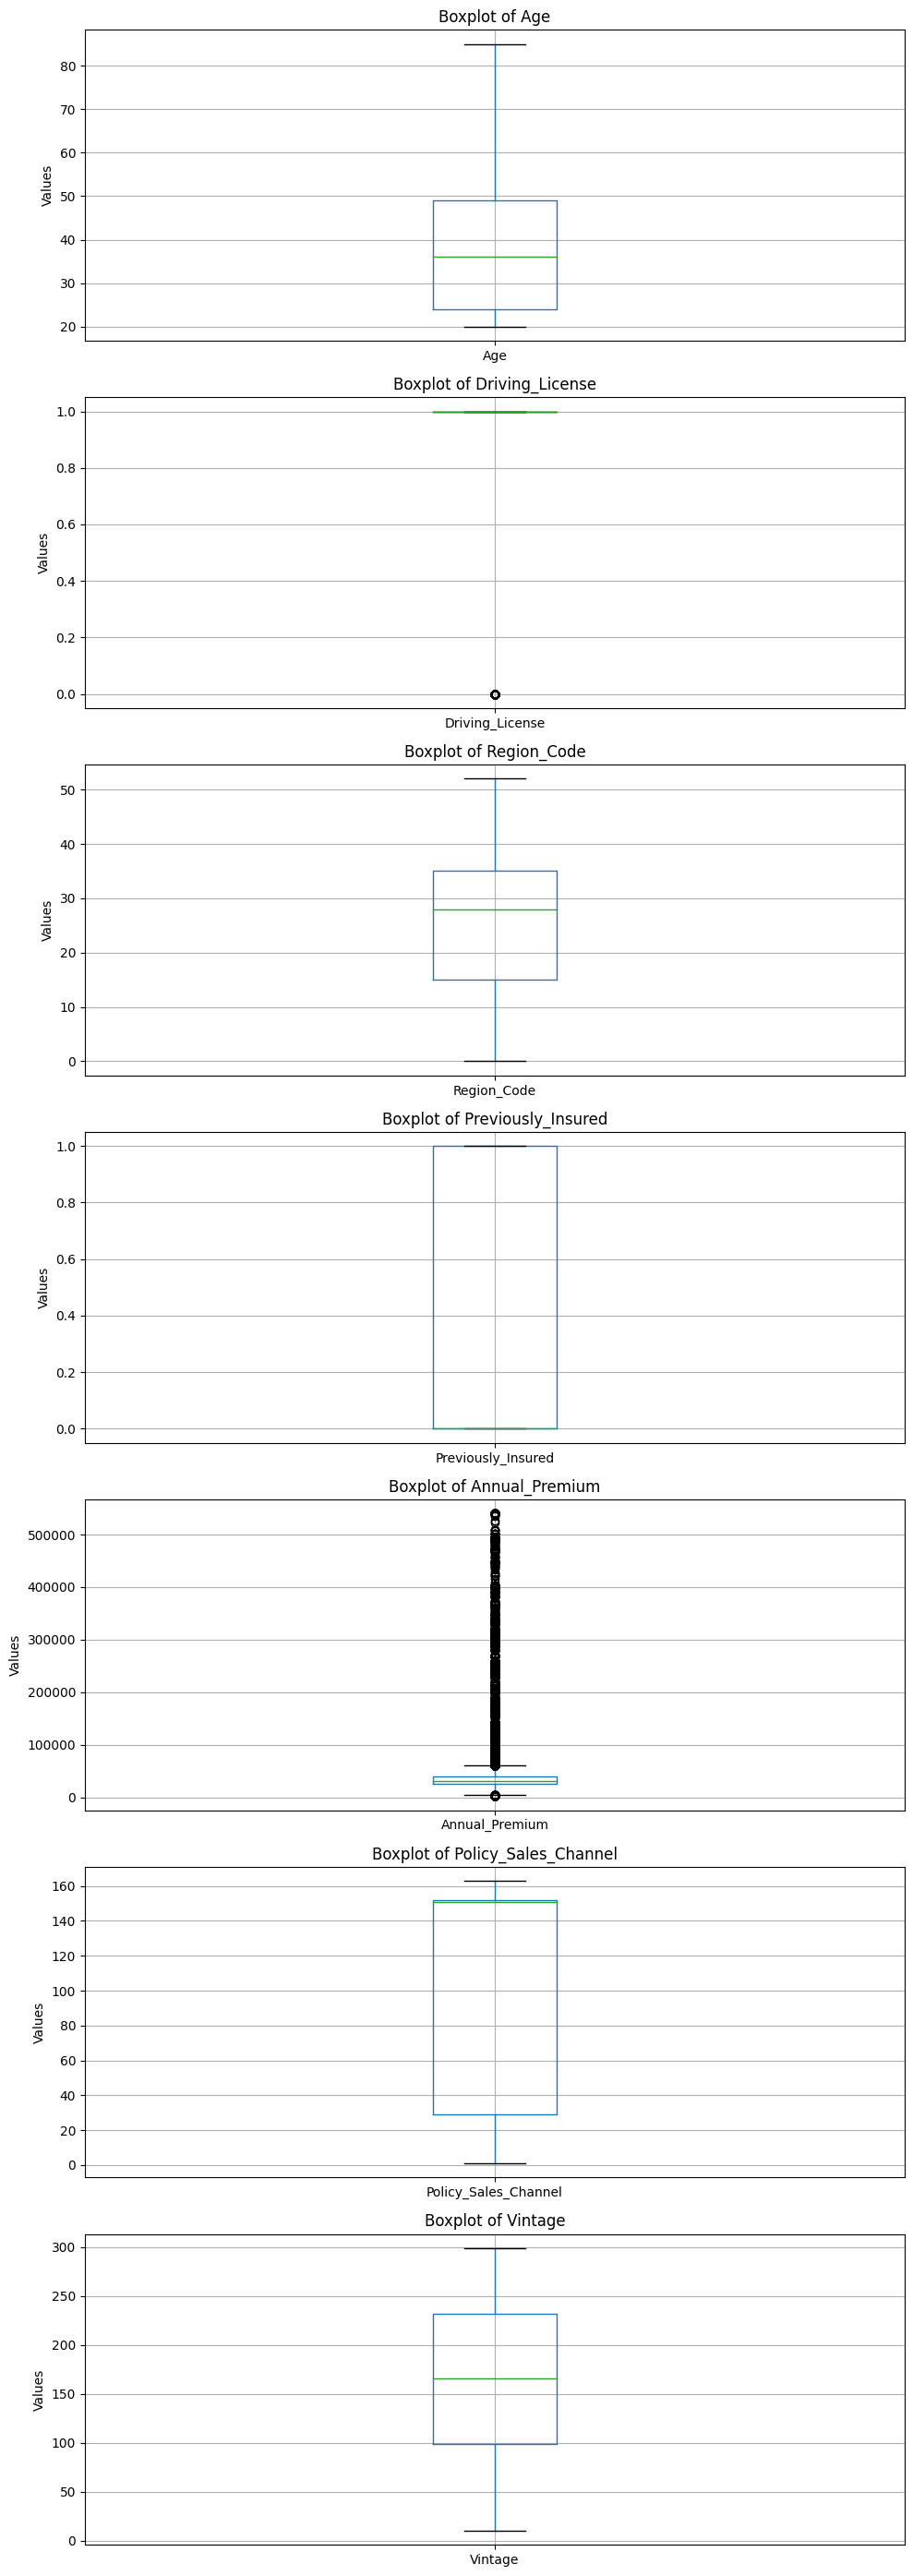

In [14]:
num_cols = len(continuous)
fig, axes = plt.subplots(num_cols, 1, figsize=(10, 4 * num_cols))

for i, col in enumerate(continuous):
    train_data.boxplot(column=col, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel('')  
    axes[i].set_ylabel('Values')

plt.tight_layout()
plt.show()

### feature magnitude

In [15]:
train_data.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07
mean,3.838356e+01,9.980220e-01,2.641869e+01,4.629966e-01,3.046137e+04,1.124254e+02,1.638977e+02,1.229973e-01
std,1.499346e+01,4.443120e-02,1.299159e+01,4.986289e-01,1.645475e+04,5.403571e+01,7.997953e+01,3.284341e-01
min,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.630000e+03,1.000000e+00,1.000000e+01,0.000000e+00
25%,2.400000e+01,1.000000e+00,1.500000e+01,0.000000e+00,2.527700e+04,2.900000e+01,9.900000e+01,0.000000e+00
50%,3.600000e+01,1.000000e+00,2.800000e+01,0.000000e+00,3.182400e+04,1.510000e+02,1.660000e+02,0.000000e+00
75%,4.900000e+01,1.000000e+00,3.500000e+01,1.000000e+00,3.945100e+04,1.520000e+02,2.320000e+02,0.000000e+00
max,8.500000e+01,1.000000e+00,5.200000e+01,1.000000e+00,5.401650e+05,1.630000e+02,2.990000e+02,1.000000e+00


# Split the data

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    train_data.drop('Response', axis=1),  # predictors
    train_data['Response'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((8053358, 10), (3451440, 10))

# Categorical encoding and rare labels

In [17]:
X_train[categorical].nunique()

Gender            2
Vehicle_Age       3
Vehicle_Damage    2
dtype: int64

In [18]:
for var in categorical:
    print(X_train[var].value_counts(normalize=True).sort_values())

Gender
Female    0.458656
Male      0.541344
Name: proportion, dtype: float64
Vehicle_Age
> 2 Years    0.041525
< 1 Year     0.438591
1-2 Year     0.519883
Name: proportion, dtype: float64
Vehicle_Damage
No     0.497505
Yes    0.502495
Name: proportion, dtype: float64


### Ordered-Ordinal-Encoding

In [19]:
def find_category_mappings(df, variable, target):

    # first  we generate an ordered list with the labels
    ordered_labels = target.groupby(df[variable]).mean().sort_values().index

    # return the dictionary with mappings
    return {k: i for i, k in enumerate(ordered_labels, 0)}


def integer_encode(train, test, variable, ordinal_mapping):

    train[variable] = train[variable].map(ordinal_mapping)
    test[variable] = test[variable].map(ordinal_mapping)

In [20]:
mappings_list = []

for variable in categorical:

    mappings = find_category_mappings(X_train, variable, y_train)
    
    mappings_list.append(mappings)

    integer_encode(X_train, X_test, variable, mappings)

In [21]:
mappings_list

[{'Female': 0, 'Male': 1},
 {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2},
 {'No': 0, 'Yes': 1}]

# Discretisation or Variable transformation

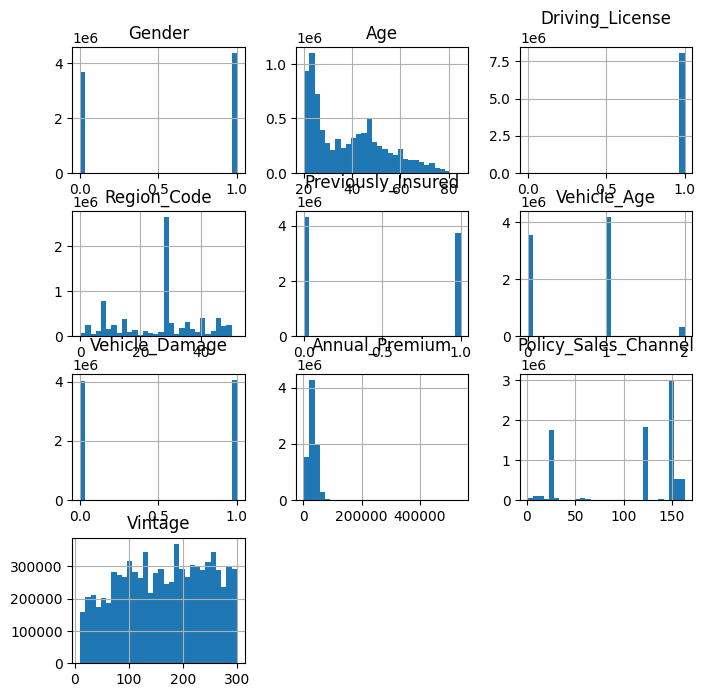

In [22]:
X_train.select_dtypes(exclude='O').hist(bins=30, figsize=(8,8))
plt.show()

For decision trees, the variable distribution is not so important, so in principle, we don't need to change it. Also decision trees are robust to outliers.

# Model

In [23]:
xgb_classifier = XGBClassifier(random_state = 0)

xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [24]:
X_train_preds = xgb_classifier.predict_proba(X_train)[:,1]
X_test_preds = xgb_classifier.predict_proba(X_test)[:,1]

In [25]:
print('Train set')
print('xgb roc-auc: {}'.format(roc_auc_score(y_train, X_train_preds)))

print('Test set')
print('xgb roc-auc: {}'.format(roc_auc_score(y_test, X_test_preds)))

Train set
xgb roc-auc: 0.8792109708857893
Test set
xgb roc-auc: 0.8782258762613604


# let's explore the importance of the features

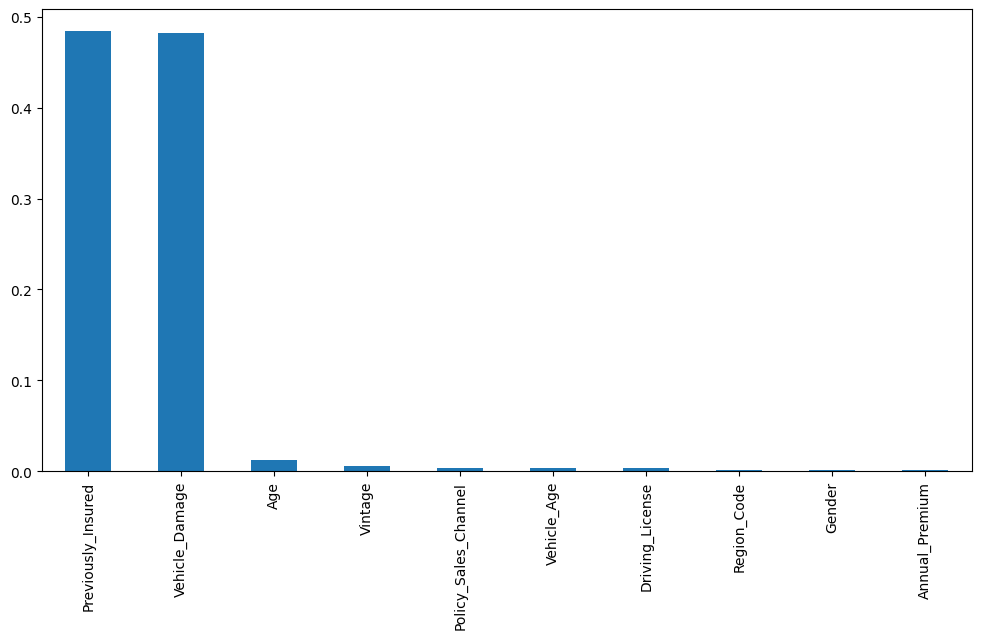

In [26]:
importance = pd.Series(xgb_classifier.feature_importances_)
importance.index = train_data.drop('Response', axis=1).columns
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(12,6))
plt.show()

# Submission

In [27]:
test_data = pd.read_csv("/kaggle/input/playground-series-s4e7/test.csv")

In [28]:
test_ids = test_data['id']

In [29]:
test_data.drop(columns = ["id"], inplace = True)

In [30]:
mappings_list

[{'Female': 0, 'Male': 1},
 {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2},
 {'No': 0, 'Yes': 1}]

In [31]:
test_data["Gender"] = test_data["Gender"].map(mappings_list[0])
test_data["Vehicle_Age"] = test_data["Vehicle_Age"].map(mappings_list[1])
test_data["Vehicle_Damage"] = test_data["Vehicle_Damage"].map(mappings_list[2])

In [32]:
predictions_test = xgb_classifier.predict_proba(test_data)[:,1]

In [33]:
result = pd.DataFrame({'id' : test_ids, 'Response' : predictions_test.flatten()}, 
                      columns=['id', 'Response'])

In [34]:
result.to_csv("/kaggle/working/submission.csv",index=False)